In [1]:
import pandas as pd
import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import darts
import math

In [2]:
# from tqdm.keras import TqdmCallback
# import tensorflow_addons as tfa
# from keras_tqdm import TQDMNotebookCallback

In [3]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.statistics import plot_acf
from darts.models.arima import ARIMA
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape

Importing plotly failed. Interactive plots will not work.


In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para alocar apenas a memória da GPU necessária para as alocações de tempo de execução
    tf.config.experimental.set_memory_growth(gpus[0], True) 
print(gpus)

[]


In [7]:
print(tf.__version__)
print(tf.keras.__version__)
import keras
print(keras.__version__)

2.1.0
2.2.4-tf
2.3.1


Using TensorFlow backend.


In [8]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from keras.layers import LSTM

In [12]:

data_path = r'/data/dibanez/tesis/data_preprocesada/'

# Preparación y Entrenamiento

## Lectura de datos

In [13]:
def print_df(df):
  print(df.shape)
  return df.head()

In [14]:
data_file = data_path+'Lima_PUCP_HIT_agg_day_hour.csv'

In [15]:
df = pd.read_csv(data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(7029, 9)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Pac,Pdc
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,NaN,NaN,NaN,NaN
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,NaN,NaN,NaN,NaN
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,NaN,NaN,NaN,NaN
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,NaN,NaN,NaN,NaN
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,NaN,NaN,NaN,NaN


## Codificación de fechas


In [18]:
start = df.iloc[0]['Fecha']
start

Timestamp('2020-02-01 06:00:00')

In [19]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
df.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Pac,Pdc,Fecha_cod
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,NaN,NaN,NaN,NaN,2020-02-01 06:00:00
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,NaN,NaN,NaN,NaN,2020-02-01 07:00:00
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,NaN,NaN,NaN,NaN,2020-02-01 08:00:00
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,NaN,NaN,NaN,NaN,2020-02-01 09:00:00
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,NaN,NaN,NaN,NaN,2020-02-01 10:00:00
5,5,2020-02-01 11:00:00,24.871774,NaN,914.490592,NaN,NaN,NaN,NaN,2020-02-01 11:00:00
6,6,2020-02-01 12:00:00,24.464188,NaN,907.603342,NaN,NaN,NaN,NaN,2020-02-01 12:00:00
7,7,2020-02-01 13:00:00,24.225858,NaN,788.107984,NaN,NaN,NaN,NaN,2020-02-01 13:00:00
8,8,2020-02-01 14:00:00,23.270754,NaN,462.801055,NaN,NaN,NaN,NaN,2020-02-01 14:00:00
9,9,2020-02-01 15:00:00,23.069030,NaN,428.230335,NaN,NaN,NaN,NaN,2020-02-01 15:00:00


In [20]:
fechas_origen = df.Fecha

In [21]:
fechas_origen[:11+1]

0    2020-02-01 06:00:00
1    2020-02-01 07:00:00
2    2020-02-01 08:00:00
3    2020-02-01 09:00:00
4    2020-02-01 10:00:00
5    2020-02-01 11:00:00
6    2020-02-01 12:00:00
7    2020-02-01 13:00:00
8    2020-02-01 14:00:00
9    2020-02-01 15:00:00
10   2020-02-01 16:00:00
11   2020-02-02 06:00:00
Name: Fecha, dtype: datetime64[ns]

## Preprocesamiento

In [22]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tamb', 'Irradiancia'])#, freq='H')
type(series_raw)

darts.timeseries.TimeSeries

In [23]:
col_obj = 'Pac'

In [24]:
series_raw[col_obj]

                             Pac
Fecha_cod                       
2020-02-01 06:00:00          NaN
2020-02-01 07:00:00          NaN
2020-02-01 08:00:00          NaN
2020-02-01 09:00:00          NaN
2020-02-01 10:00:00          NaN
...                          ...
2020-11-19 22:00:00  1108.416667
2020-11-19 23:00:00   785.083333
2020-11-20 00:00:00   495.400000
2020-11-20 01:00:00   303.366667
2020-11-20 02:00:00   176.050000

[7029 rows x 1 columns]
Freq: H

In [33]:
series_raw[col_obj][50:60]

                             Pac
Fecha_cod                       
2020-02-03 08:00:00  1288.561112
2020-02-03 09:00:00  1274.900000
2020-02-03 10:00:00  1127.644068
2020-02-03 11:00:00   871.762712
2020-02-03 12:00:00   400.242783
2020-02-03 13:00:00    50.850000
2020-02-03 14:00:00   195.779661
2020-02-03 15:00:00   572.562248
2020-02-03 16:00:00   913.950000
2020-02-03 17:00:00  1169.433333
Freq: H

In [34]:
len(series_raw)

7029

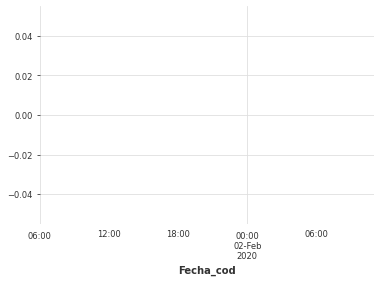

In [35]:
series_raw[0:30]['Pac'].plot()

### Imputación de datos faltantes

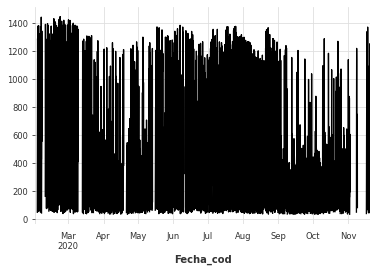

In [41]:
series_raw['Pac'].plot()

In [42]:
series_raw

                             Pac       Tamb  Irradiancia
Fecha_cod                                               
2020-02-01 06:00:00          NaN  22.026791    27.115116
2020-02-01 07:00:00          NaN  21.722877   111.537495
2020-02-01 08:00:00          NaN  22.832072   416.345874
2020-02-01 09:00:00          NaN  23.769869   557.163245
2020-02-01 10:00:00          NaN  25.171561   843.467267
...                          ...        ...          ...
2020-11-19 22:00:00  1108.416667        NaN   798.730385
2020-11-19 23:00:00   785.083333        NaN   553.831272
2020-11-20 00:00:00   495.400000        NaN   350.109017
2020-11-20 01:00:00   303.366667        NaN   217.974865
2020-11-20 02:00:00   176.050000        NaN   134.131085

[7029 rows x 3 columns]
Freq: H

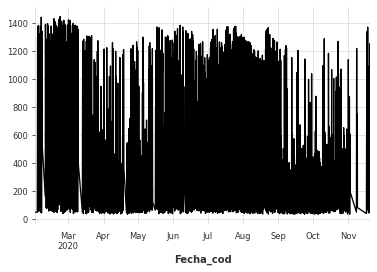

In [44]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series['Pac'].plot()

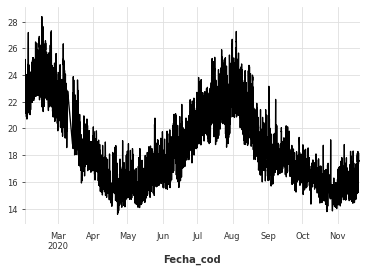

In [46]:
series['Tamb'].plot()

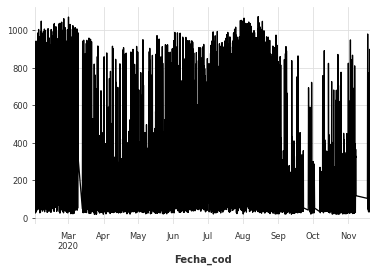

In [47]:
series['Irradiancia'].plot()

### Separación de conjuntos de entrenamiento y validación

In [48]:
train_perc = .8
math.ceil(len(series)*train_perc)

5624

In [49]:
val_len = int(len(series)*(1-train_perc))

In [50]:
val_len -= val_len%11

In [51]:
val_len

1397

In [52]:
train, val = series[:-val_len], series[-val_len:]

In [53]:
train

                            Pac       Tamb  Irradiancia
Fecha_cod                                              
2020-02-01 06:00:00   48.090909  22.026791    27.115116
2020-02-01 07:00:00   48.090909  21.722877   111.537495
2020-02-01 08:00:00   48.090909  22.832072   416.345874
2020-02-01 09:00:00   48.090909  23.769869   557.163245
2020-02-01 10:00:00   48.090909  25.171561   843.467267
...                         ...        ...          ...
2020-09-22 17:00:00  523.983333  18.131548   355.140571
2020-09-22 18:00:00  526.216667  18.430790   358.687698
2020-09-22 19:00:00  323.666667  18.072161   225.177529
2020-09-22 20:00:00  188.616667  17.686777   134.005215
2020-09-22 21:00:00   71.160000  17.312989    54.119073

[5632 rows x 3 columns]
Freq: H

## Visualización

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

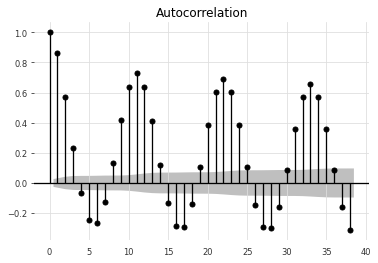

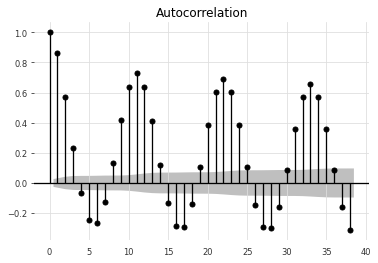

In [55]:
plot_acf(train[col_obj].values())

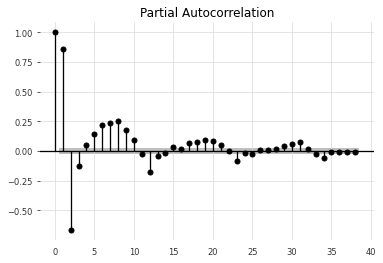

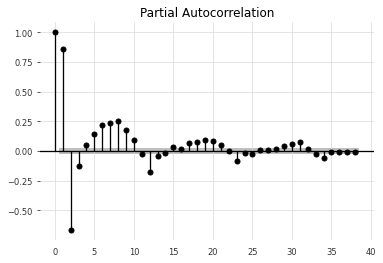

In [56]:
plot_pacf(train[col_obj].values())

## Training (ARIMA)

In [57]:
model = ARIMA(p=2, d=0, q=11)

In [58]:
%%time
model.fit(train[col_obj])

CPU times: user 16min 12s, sys: 20min 9s, total: 36min 22s
Wall time: 1min 38s


In [59]:
train

                            Pac       Tamb  Irradiancia
Fecha_cod                                              
2020-02-01 06:00:00   48.090909  22.026791    27.115116
2020-02-01 07:00:00   48.090909  21.722877   111.537495
2020-02-01 08:00:00   48.090909  22.832072   416.345874
2020-02-01 09:00:00   48.090909  23.769869   557.163245
2020-02-01 10:00:00   48.090909  25.171561   843.467267
...                         ...        ...          ...
2020-09-22 17:00:00  523.983333  18.131548   355.140571
2020-09-22 18:00:00  526.216667  18.430790   358.687698
2020-09-22 19:00:00  323.666667  18.072161   225.177529
2020-09-22 20:00:00  188.616667  17.686777   134.005215
2020-09-22 21:00:00   71.160000  17.312989    54.119073

[5632 rows x 3 columns]
Freq: H

In [60]:
n_predict = 80

In [61]:
%%time
pred = model.predict(n_predict)
pred

CPU times: user 455 ms, sys: 563 ms, total: 1.02 s
Wall time: 46.8 ms


                              0
2020-09-22 22:00:00   79.882133
2020-09-22 23:00:00  152.063342
2020-09-23 00:00:00  266.440793
2020-09-23 01:00:00  393.534066
2020-09-23 02:00:00  516.751887
...                         ...
2020-09-26 01:00:00  462.434490
2020-09-26 02:00:00  382.398055
2020-09-26 03:00:00  343.614906
2020-09-26 04:00:00  358.342902
2020-09-26 05:00:00  421.849393

[80 rows x 1 columns]
Freq: H

In [62]:
val[:100]

                            Pac       Tamb  Irradiancia
Fecha_cod                                              
2020-09-22 22:00:00   55.774444  16.134004    54.002475
2020-09-22 23:00:00   40.388889  16.341793    53.885877
2020-09-23 00:00:00   98.133333  16.700497    53.769278
2020-09-23 01:00:00  139.200000  16.996799    53.652680
2020-09-23 02:00:00  211.083333  17.456944    53.536082
...                         ...        ...          ...
2020-09-26 21:00:00  363.210526  17.379334    42.925651
2020-09-26 22:00:00  332.241379  17.396986    42.809053
2020-09-26 23:00:00  268.333333  17.481831    42.692454
2020-09-27 00:00:00  109.733333  17.463460    42.575856
2020-09-27 01:00:00   82.679167  16.122010    42.459258

[100 rows x 3 columns]
Freq: H

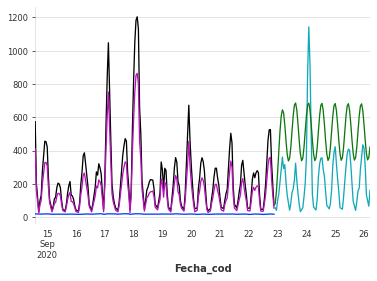

In [63]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [66]:
# %%time
# model.backtest(val,forecast_horizon=11, verbose=True)

In [67]:
print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

MAPE: 62.39%


In [68]:
# plot_acf(train)

## Training (CNN)

In [69]:
df_columns = ['Pac', 'Tamb','Irradiancia']

In [70]:
arr_train = train.values()
arr_train

array([[ 48.09090909,  22.02679129,  27.11511623],
       [ 48.09090909,  21.72287734, 111.53749515],
       [ 48.09090909,  22.83207246, 416.34587411],
       ...,
       [323.66666667,  18.07216135, 225.17752931],
       [188.61666667,  17.68677694, 134.00521525],
       [ 71.16      ,  17.31298873,  54.11907288]])

In [71]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [72]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5611, 11, 3) (5611, 11)


In [73]:
print(X[0], y[0])

[[ 48.09090909  22.02679129  27.11511623]
 [ 48.09090909  21.72287734 111.53749515]
 [ 48.09090909  22.83207246 416.34587411]
 [ 48.09090909  23.76986884 557.16324529]
 [ 48.09090909  25.17156142 843.46726672]
 [ 48.09090909  24.87177409 914.49059164]
 [ 48.09090909  24.46418762 907.6033424 ]
 [ 48.09090909  24.22585824 788.10798363]
 [ 48.09090909  23.27075443 462.80105468]
 [ 48.09090909  23.06902988 428.23033495]
 [ 48.09090909  22.91749311 258.95168776]] [48.09090909 48.09090909 48.09090909 48.09090909 48.09090909 48.09090909
 48.09090909 48.09090909 48.09090909 48.09090909 48.09090909]


In [74]:
X.shape

(5611, 11, 3)

In [75]:
y.shape

(5611, 11)

In [76]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
modelo_cnn.add(MaxPooling1D(pool_size=2))
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(50, activation='relu'))
modelo_cnn.add(Dense(n_steps_out))
modelo_cnn.compile(optimizer='adam', loss='mse')

# entrena el modelo Vector-Output Mulkti-step MLP con la la data de entrenamiento generada
hist_cnn = modelo_cnn.fit(X, y, epochs=2000, verbose=1)#, callbacks=[TqdmCallback(verbose=2)])




Epoch 1/2000
5611/5611 [==============================] - 1s 111us/step - loss: 90715.5038
Epoch 2/2000
5611/5611 [==============================] - 0s 78us/step - loss: 59827.1777
Epoch 3/2000
5611/5611 [==============================] - 0s 78us/step - loss: 57163.7008
Epoch 4/2000
5611/5611 [==============================] - 0s 78us/step - loss: 55397.6111
Epoch 5/2000
5611/5611 [==============================] - 0s 78us/step - loss: 54048.6903
Epoch 6/2000
5611/5611 [==============================] - 0s 78us/step - loss: 52889.4634
Epoch 7/2000
5611/5611 [==============================] - 0s 78us/step - loss: 51883.5515
Epoch 8/2000
5611/5611 [==============================] - 0s 78us/step - loss: 51061.6581
Epoch 9/2000
5611/5611 [==============================] - 0s 77us/step - loss: 50555.3289
Epoch 10/2000
5611/5611 [==============================] - 0s 79us/step - loss: 50051.9947
Epoch 11/2000
5611/5611 [==============================] - 0s 79us/step - loss: 49822.1133
Epoch 1

In [143]:
#14 min

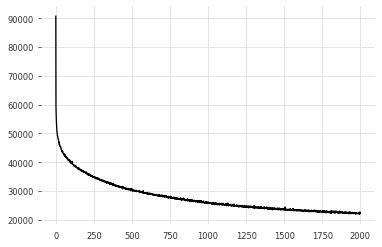

In [77]:
plt.plot(hist_cnn.history['loss'])

In [80]:
# muestra un resumen de la topologia del modelo
modelo_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            448       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                561       
Total params: 17,059
Trainable params: 17,059
Non-trainable params: 0
_________________________________________________________________


In [81]:
# modelo_cnn = modelo

In [82]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 12ms/step


array([[123.0609 , 129.33481, 206.97173, 294.19205, 428.2492 , 551.20105,
        632.47   , 607.7903 , 460.05643, 274.32196, 103.06725]],
      dtype=float32)

# Comparación de modelos


### Definicion Walkforward

In [83]:
def walk_forward_evaluation(train, val, model, n_pred, col_obj, es_neuronal=False):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    history = train
    if es_neuronal:
        pass #model.fit(train)
    arr_pred=None
    arr_real=None 
    for t in range(len(val)-n_pred):
        print(f't={t}/{len(val)-n_pred-1}')
        print(f'history len = {len(history)}')
        print()
        
        #valores predichos
        if not es_neuronal:
            model.fit(history[col_obj])
            pred = model.predict(n_pred)
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        history = history.append(val[t])
    
    return arr_pred, arr_real
    

#### Walk forward para modelos neuronales

In [84]:
def walk_forward_evaluation_neuronal(train, val, model, n_pred, col_obj, es_neuronal=True):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    x_input = train[-11:]
    if es_neuronal:
        pass #model.fit(train)
    
    arr_pred=None
    arr_real=None 
    for t in range(val.shape[0]-n_pred):
        if (t%100 == 0) or (t == (val.shape[0]-n_pred-1)):
            print(f't={t}/{val.shape[0]-n_pred-1}')
            print(f'history len = {x_input.shape[0]}')
            print()
        
        #valores predichos
        if not es_neuronal:
#             model.fit(history[col_obj])
            pred = model.predict(n_pred)
        else:
            pred = model.predict(x_input.reshape((1, 11, train.shape[1])) )
            
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
            
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        if not es_neuronal:
            real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        else:
            real = val[t:t+n_pred,0].reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        x_input = np.vstack((x_input[1:],val[t]))
    
    return arr_pred, arr_real
    

### Prediction CNN


In [85]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[123.0609 , 129.33481, 206.97173, 294.19205, 428.2492 , 551.20105,
        632.47   , 607.7903 , 460.05643, 274.32196, 103.06725]],
      dtype=float32)

In [86]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[123.0609 , 129.33481, 206.97173, 294.19205, 428.2492 , 551.20105,
        632.47   , 607.7903 , 460.05643, 274.32196, 103.06725]],
      dtype=float32)

### Walk Forward CNN

In [121]:
model = modelo_cnn
n_pred = 11
val_wfe = val.values()[:n_pred*2] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

5632
22


In [122]:
n_features

3

In [123]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/10
history len = 11

t=10/10
history len = 11

CPU times: user 15.2 ms, sys: 1.5 ms, total: 16.7 ms
Wall time: 11.9 ms


In [124]:
arr_pred

array([[ 123.0609   ,  129.33481  ,  206.97173  ,  294.19205  ,
         428.2492   ,  551.20105  ,  632.47     ,  607.7903   ,
         460.05643  ,  274.32196  ,  103.06725  ],
       [  82.385086 ,  136.81906  ,  217.57991  ,  305.97162  ,
         402.39697  ,  462.7941   ,  440.62552  ,  350.3047   ,
         229.8537   ,  136.67711  ,  114.40024  ],
       [  79.45291  ,  166.84566  ,  248.65352  ,  320.71246  ,
         356.02393  ,  355.5458   ,  279.46152  ,  145.9793   ,
          44.011597 ,   48.985954 ,  108.72446  ],
       [ 241.20299  ,  377.44095  ,  513.50775  ,  589.00574  ,
         527.2942   ,  406.04794  ,  284.355    ,  169.23996  ,
         151.2049   ,  187.43394  ,  254.6186   ],
       [ 195.38487  ,  300.1131   ,  434.8881   ,  529.48096  ,
         491.1831   ,  363.88895  ,  221.48387  ,  144.77779  ,
         123.8065   ,  157.65858  ,  223.44843  ],
       [ 249.77892  ,  293.19876  ,  271.44794  ,  258.679    ,
         196.74992  ,  157.81342  ,  188.

In [125]:
arr_real

array([[ 55.77444444,  40.38888889,  98.13333333, 139.2       ,
        211.08333333, 285.71666667, 360.43333333, 291.5       ,
        315.28333333, 209.33333333, 131.91666667],
       [ 40.38888889,  98.13333333, 139.2       , 211.08333333,
        285.71666667, 360.43333333, 291.5       , 315.28333333,
        209.33333333, 131.91666667,  86.61050725],
       [ 98.13333333, 139.2       , 211.08333333, 285.71666667,
        360.43333333, 291.5       , 315.28333333, 209.33333333,
        131.91666667,  86.61050725,  41.30434783],
       [139.2       , 211.08333333, 285.71666667, 360.43333333,
        291.5       , 315.28333333, 209.33333333, 131.91666667,
         86.61050725,  41.30434783,  81.56666667],
       [211.08333333, 285.71666667, 360.43333333, 291.5       ,
        315.28333333, 209.33333333, 131.91666667,  86.61050725,
         41.30434783,  81.56666667, 146.55      ],
       [285.71666667, 360.43333333, 291.5       , 315.28333333,
        209.33333333, 131.91666667,  86.6

#### Metric Evaluation CNN

In [126]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [127]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 58.1247307 ,  70.52226527, 113.29399699, 138.14799874,
       143.71243783, 133.62168259, 172.0604258 , 214.90170214,
       183.14245553, 192.48845278, 186.058928  ])

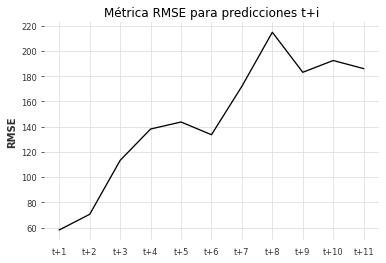

In [128]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [129]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 0.68871602,  0.51615153,  0.24841854,  0.41481444,  0.34568132,
        0.33178561, -0.22708281, -0.55862351, -0.03551419,  0.03457155,
        0.2898995 ])

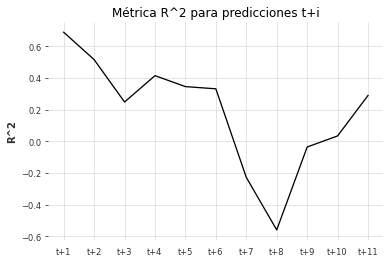

In [130]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

In [131]:
arr_pred

array([[ 123.0609   ,  129.33481  ,  206.97173  ,  294.19205  ,
         428.2492   ,  551.20105  ,  632.47     ,  607.7903   ,
         460.05643  ,  274.32196  ,  103.06725  ],
       [  82.385086 ,  136.81906  ,  217.57991  ,  305.97162  ,
         402.39697  ,  462.7941   ,  440.62552  ,  350.3047   ,
         229.8537   ,  136.67711  ,  114.40024  ],
       [  79.45291  ,  166.84566  ,  248.65352  ,  320.71246  ,
         356.02393  ,  355.5458   ,  279.46152  ,  145.9793   ,
          44.011597 ,   48.985954 ,  108.72446  ],
       [ 241.20299  ,  377.44095  ,  513.50775  ,  589.00574  ,
         527.2942   ,  406.04794  ,  284.355    ,  169.23996  ,
         151.2049   ,  187.43394  ,  254.6186   ],
       [ 195.38487  ,  300.1131   ,  434.8881   ,  529.48096  ,
         491.1831   ,  363.88895  ,  221.48387  ,  144.77779  ,
         123.8065   ,  157.65858  ,  223.44843  ],
       [ 249.77892  ,  293.19876  ,  271.44794  ,  258.679    ,
         196.74992  ,  157.81342  ,  188.

## Training (LSTM)

In [132]:
# my_model = RNNModel(
#     model='LSTM',
#     dropout=0,
#     batch_size=16,
#     n_epochs=300,
#     optimizer_kwargs={'lr': 1e-3}, 
#     model_name='LSTM_model',
#     log_tensorboard=True,
#     random_state=42,
#     input_chunk_length=11,
#     output_chunk_length=11
# )

In [133]:
# %%time
# my_model.fit(train[col_obj],
#              val_series=val[col_obj],
#              verbose=True)

In [134]:
df_columns = ['Pac', 'Tamb']

In [135]:
arr_train = train.values()
arr_train

array([[ 48.09090909,  22.02679129,  27.11511623],
       [ 48.09090909,  21.72287734, 111.53749515],
       [ 48.09090909,  22.83207246, 416.34587411],
       ...,
       [323.66666667,  18.07216135, 225.17752931],
       [188.61666667,  17.68677694, 134.00521525],
       [ 71.16      ,  17.31298873,  54.11907288]])

In [136]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [137]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5611, 11, 3) (5611, 11)


In [138]:
print(X[0], y[0])

[[ 48.09090909  22.02679129  27.11511623]
 [ 48.09090909  21.72287734 111.53749515]
 [ 48.09090909  22.83207246 416.34587411]
 [ 48.09090909  23.76986884 557.16324529]
 [ 48.09090909  25.17156142 843.46726672]
 [ 48.09090909  24.87177409 914.49059164]
 [ 48.09090909  24.46418762 907.6033424 ]
 [ 48.09090909  24.22585824 788.10798363]
 [ 48.09090909  23.27075443 462.80105468]
 [ 48.09090909  23.06902988 428.23033495]
 [ 48.09090909  22.91749311 258.95168776]] [48.09090909 48.09090909 48.09090909 48.09090909 48.09090909 48.09090909
 48.09090909 48.09090909 48.09090909 48.09090909 48.09090909]


In [139]:
X.shape

(5611, 11, 3)

In [140]:
y.shape

(5611, 11)

### Modelo LSTM 1

In [141]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
modelo.add(LSTM(10, activation='relu'))
modelo.add(Dense(n_steps_out))
modelo.compile(optimizer='adam', loss='mse')

# entrena el modelo Stacked LSTM Vector-Output con la la data de entrenamiento generada
hist = modelo.fit(X, y, epochs=738, verbose=1)



Epoch 1/738
5611/5611 [==============================] - 3s 567us/step - loss: 343680.3255
Epoch 2/738
5611/5611 [==============================] - 3s 484us/step - loss: 234420.5334
Epoch 3/738
5611/5611 [==============================] - 3s 482us/step - loss: 161923.8617
Epoch 4/738
5611/5611 [==============================] - 3s 482us/step - loss: 158679.0643
Epoch 5/738
5611/5611 [==============================] - 3s 483us/step - loss: 139221.5035
Epoch 6/738
5611/5611 [==============================] - 3s 483us/step - loss: 113580.2574
Epoch 7/738
5611/5611 [==============================] - 3s 482us/step - loss: 96859.4567
Epoch 8/738
5611/5611 [==============================] - 3s 486us/step - loss: 89477.5866
Epoch 9/738
5611/5611 [==============================] - 3s 483us/step - loss: 89460.8796
Epoch 10/738
5611/5611 [==============================] - 3s 481us/step - loss: 89158.8527
Epoch 11/738
5611/5611 [==============================] - 3s 483us/step - loss: 84826.8471
Ep

In [142]:
#24m

In [144]:
modelo_lstm = modelo
hist_lstm = hist

In [145]:
# muestra un resumen de la topologia del modelo
modelo_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                121       
Total params: 13,361
Trainable params: 13,361
Non-trainable params: 0
_________________________________________________________________


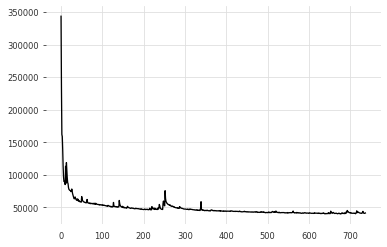

In [146]:
plt.plot(hist_lstm.history['loss'])

In [147]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 67ms/step


array([[ 53.381287,  80.120125, 171.00848 , 286.55508 , 396.08008 ,
        487.3205  , 538.1212  , 512.4971  , 409.5149  , 255.81145 ,
        107.99657 ]], dtype=float32)

### Prediction LSTM


In [148]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 3ms/step


array([[ 53.381287,  80.120125, 171.00848 , 286.55508 , 396.08008 ,
        487.3205  , 538.1212  , 512.4971  , 409.5149  , 255.81145 ,
        107.99657 ]], dtype=float32)

### Walk Forward LSTM 2

In [146]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values()#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
748


In [147]:
n_features

2

In [148]:
val_wfe.shape

(748, 2)

In [150]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/736
history len = 11

t=100/736
history len = 11

t=200/736
history len = 11

t=300/736
history len = 11

t=400/736
history len = 11

t=500/736
history len = 11

t=600/736
history len = 11

t=700/736
history len = 11

t=736/736
history len = 11

CPU times: user 8.73 s, sys: 2.98 s, total: 11.7 s
Wall time: 3.58 s


In [151]:
arr_pred

array([[ 752.02496, 1104.2043 , 1588.499  , ..., 1239.8743 ,  747.08777,
         504.43246],
       [ 820.05145, 1306.9363 , 1841.2429 , ...,  828.26196,  533.5449 ,
         522.4703 ],
       [1568.9072 , 2189.14   , 2642.2615 , ...,  508.64752,  541.48804,
         906.61523],
       ...,
       [1542.2753 , 1050.1046 ,  742.8504 , ..., 2620.6755 , 2386.381  ,
        1924.2051 ],
       [1028.1779 ,  720.0308 ,  686.06793, ..., 2433.1772 , 2032.0206 ,
        1498.0194 ],
       [ 453.5025 ,  566.65045, 1018.3973 , ..., 1941.5226 , 1417.6671 ,
         957.3479 ]], dtype=float32)

In [152]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, ..., 1830.59958333,
        1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, ..., 1196.37333333,
         483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, ...,  483.49708333,
         419.27583333, 1134.27166667],
       ...,
       [1807.55041667, 1250.87416667,  421.00041667, ..., 2542.35708333,
        2491.33625   , 2270.21666667],
       [1250.87416667,  421.00041667,  425.24208333, ..., 2491.33625   ,
        2270.21666667, 1745.28583333],
       [ 421.00041667,  425.24208333, 1057.35625   , ..., 2270.21666667,
        1745.28583333, 1222.64541667]])

#### Metric Evaluation LSTM

In [153]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [154]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([263.91691279, 293.3743812 , 303.64209429, 314.79830362,
       337.3748984 , 362.89453073, 371.40991697, 374.29053298,
       383.32809237, 365.551063  , 346.74699497])

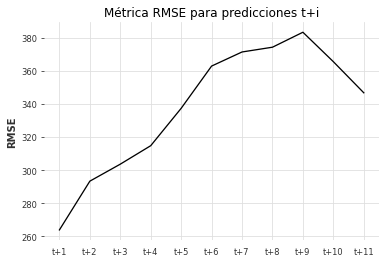

In [155]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [156]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.8830049 , 0.83470742, 0.80669159, 0.78495951, 0.7358263 ,
       0.68766291, 0.70243414, 0.73059582, 0.72695168, 0.75454937,
       0.7787712 ])

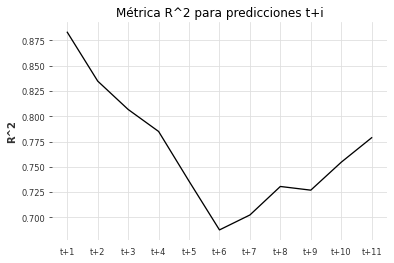

In [157]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Walk Forward LSTM

In [187]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values()[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [188]:
n_features

2

In [189]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/21
history len = 11

t=1/21
history len = 11

t=2/21
history len = 11

t=3/21
history len = 11

t=4/21
history len = 11

t=5/21
history len = 11

t=6/21
history len = 11

t=7/21
history len = 11

t=8/21
history len = 11

t=9/21
history len = 11

t=10/21
history len = 11

t=11/21
history len = 11

t=12/21
history len = 11

t=13/21
history len = 11

t=14/21
history len = 11

t=15/21
history len = 11

t=16/21
history len = 11

t=17/21
history len = 11

t=18/21
history len = 11

t=19/21
history len = 11

t=20/21
history len = 11

t=21/21
history len = 11

CPU times: user 238 ms, sys: 67.2 ms, total: 305 ms
Wall time: 102 ms


In [190]:
arr_pred

array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314],
       [ 737.5334 , 1241.9738 , 1720.9745 , 2091.577  , 2285.7573 ,
        2280.4714 , 2039.9794 , 1579.5532 ,  986.767  ,  465.55008,
         379.3336 ],
       [1708.7362 , 2033.2561 , 2169.305  , 2285.4094 , 2399.606  ,
        2276.7283 , 1734.406  ,  988.9572 ,  515.4057 ,  562.57416,
        1035.902  ],
       [2146.0974 , 2341.3909 , 2341.6892 , 2238.6692 , 2063.3533 ,
        1654.9498 , 1020.3772 ,  512.823  ,  541.0208 , 1062.4093 ,
        1715.3575 ],
       [2357.3774 , 2431.8064 , 2301.9375 , 1942.7925 , 1433.8888 ,
         880.18823,  506.30902,  562.7502 , 1056.2153 , 1673.8301 ,
        2184.635  ],
       [2513.2107 , 2453.1042 , 2152.5264 , 1581.799  ,  896.07104,
         406.41943,  395.2406 ,  908.8264 , 1604.0752 , 2086.71   ,
        2391.2146 ],
       [2407.9592 , 2057.7625 , 1500.4854 ,  858.83453,  3

In [191]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation LSTM

In [192]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [193]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
       274.55980543, 231.67606308, 221.54597819, 211.42255549,
       184.07502815, 164.89740173, 124.90828435])

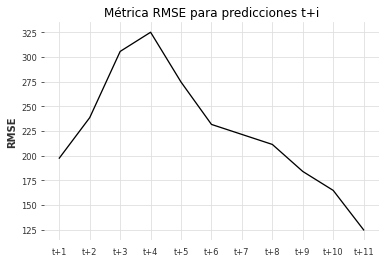

In [194]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [195]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
       0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
       0.97196451])

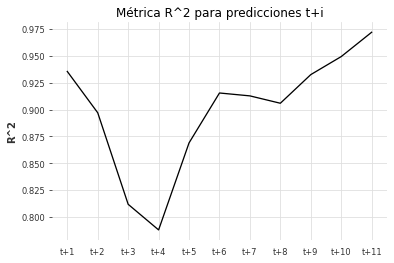

In [196]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()